## **Random Forests and Ensemble methods**

If you aggregate the predictions of a group of predictors, you will often get better predictions compared to the best individual predictors. A group of predictors is called an **ensemble**, thus this technique is called **Ensemble Learning**

For example, you can train a group of Decision Tree classifiers, each on a different random subset of the training set. To make predictions, you just obtain the predictions of all individual trees, then predict the class that gets the most votes. Such an ensemble of Decision Trees is called a **Random Forest**

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ensembles"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## **Voting Classifiers**

Suppose you have trained a few classifiers, each one achieving about 80% accuracy.
You may have a Logistic Regression classifier, an SVM classifier, a Random Forest
classifier, a K-Nearest Neighbors classifier, and perhaps a few more

A very simple way to create an even better classifier is to aggregate the predictions of each classifier and predict the class that gets the most votes. This majority-vote classifier is called a **hard voting classifier**

In [4]:
# Using Moon's dataset and building three different classifiers

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Linear classifier that models P(y=1|x) using a logistic function
log_clf = LogisticRegression(solver="lbfgs", random_state=42)

# Ensemble of decision trees trained on random feature/data subsets
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Kernel-based classifier that finds a non-linear decision boundary
svm_clf = SVC(gamma="scale", random_state=42)

# Combine multiple classifiers and predict the class chosen by majority vote
voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard'  # Uses predicted class labels (not probabilities)
)

In [6]:
voting_clf.fit(X_train, y_train)

,estimators,"[('lr', ...), ('rf', ...), ...]"
,voting,'hard'
,weights,None
,n_jobs,None
,flatten_transform,True
,verbose,False
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True


In [ ]:
from sklearn.metrics import accuracy_score

# Train and evaluate each classifier individually and as an ensemble
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)              # Train the model
    y_pred = clf.predict(X_test)           # Predict labels for unseen data
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))  # Report accuracy

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


## **Bagging and Pasting**

One way to get a diverse set of classifiers is to use very different training algorithms, as just discussed. Another approach is to use the same training algorithm for every predictor, but to train them on different random subsets of the training set. 

When sampling is performed with replacement, this method is called **Bagging** (short for bootstrap aggregating). When sampling is performed without replacement, it is called **Pasting**.

In other words, *both bagging and pasting allow training instances to be sampled several times across multiple predictors*, but only bagging allows training instances to be sampled several times for the same predictor.

### *In Summary*
Both methods create diverse classifiers by training the **same algorithm** on **different subsets of the data**, instead of changing the algorithm itself

- Bagging samples with replacement, meaning the *same data point can appear multiple times in one model’s training set*.

- Pasting samples without replacement, so *each data point appears at most once per model*

Bagging introduces more randomness and **reduces variance more aggressively**, while **pasting is simpler** but slightly less robust

Many models (especially decision trees) have high variance.
That means:

- They overreact to noise

- They fit quirks of the dataset

- They generalize poorly

Bagging and pasting attack this by forcing models to disagree in controlled ways, then averaging out their errors.

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# Create a bagging ensemble of 500 decision trees
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(),      # Base estimator used in the ensemble
    n_estimators=500,              # Number of trees in the ensemble
    max_samples=100,               # Each tree trained on 100 random samples
    bootstrap=True,                # Sampling with replacement (Bagging)
    random_state=42                # Ensures reproducibility
)

bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [ ]:
# Measure ensemble accuracy
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.904


In [ ]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)

# Measure single tree accuracy
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


In [13]:
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True, title_label=""):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)

    # Color regions by predicted class
    region_cmap = ListedColormap(['#fafab0', '#9898ff'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=region_cmap)

    # Draw decision boundaries
    if contour:
        boundary_cmap = ListedColormap(['#7d7d58', '#4c4c7f'])
        plt.contour(x1, x2, y_pred, cmap=boundary_cmap, alpha=0.8)

    # Plot class 0 samples
    plt.scatter(X[:, 0][y == 0], X[:, 1][y == 0],
                c='yellow', marker='o', edgecolor='k', alpha=alpha)

    # Plot class 1 samples
    plt.scatter(X[:, 0][y == 1], X[:, 1][y == 1],
                c='blue', marker='s', edgecolor='k', alpha=alpha)

    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=14)
    plt.ylabel(r"$x_2$", fontsize=14, rotation=0)
    plt.title(title_label, fontsize=14)

    # Legend elements (shared meaning across both plots)
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label='Class 0',
               markerfacecolor='yellow', markeredgecolor='k', markersize=8),
        Line2D([0], [0], marker='s', color='w', label='Class 1',
               markerfacecolor='blue', markeredgecolor='k', markersize=8),
        Patch(facecolor='#fafab0', edgecolor='k', label='Predicted Class 0 Region'),
        Patch(facecolor='#9898ff', edgecolor='k', label='Predicted Class 1 Region')
    ]

    plt.legend(handles=legend_elements, loc="upper left", fontsize=9)


Saving figure decision_tree_without_and_with_bagging_plot


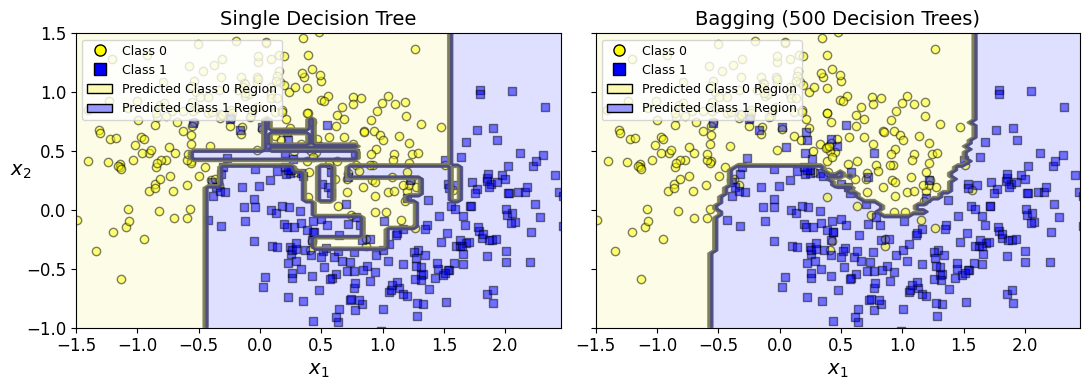

In [15]:
fig, axes = plt.subplots(ncols=2, figsize=(11, 4), sharey=True)

# Single Decision Tree
plt.sca(axes[0])
plot_decision_boundary(
    tree_clf, X, y,
    title_label="Single Decision Tree"
)

# Bagging Ensemble
plt.sca(axes[1])
plot_decision_boundary(
    bag_clf, X, y,
    title_label="Bagging (500 Decision Trees)"
)
plt.ylabel("")

save_fig("decision_tree_without_and_with_bagging_plot")
plt.tight_layout()
plt.show()

## **Out-of-Bag Evaluation**

With bagging, some instances may be sampled several times for any given predictor,
while others may not be sampled at all. By default a BaggingClassifier samples m
training instances with replacement (bootstrap=True), where m is the size of the
training set.

This means that **only about 63% of the training instances are sampled on average for each predictor**. The **remaining 37% of the training instances that are not sampled are called out-of-bag (oob) instances**. Note that they are not the same 37% for all predictors.

Since a predictor never sees the oob instances during training, it can be evaluated on these instances, without the need for a separate validation set. **You can evaluate the ensemble itself by averaging out the oob evaluations of each predictor.**

In Scikit-Learn, you can set oob_score=True when creating a BaggingClassifier to request an automatic oob evaluation after training.

In [16]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, oob_score=True, random_state=40)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.8986666666666666

In [17]:
bag_clf.oob_decision_function_

array([[0.32275132, 0.67724868],
       [0.34117647, 0.65882353],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.09497207, 0.90502793],
       [0.31147541, 0.68852459],
       [0.01754386, 0.98245614],
       [0.97109827, 0.02890173],
       [0.97765363, 0.02234637],
       [0.74404762, 0.25595238],
       [0.        , 1.        ],
       [0.7173913 , 0.2826087 ],
       [0.85026738, 0.14973262],
       [0.97222222, 0.02777778],
       [0.0625    , 0.9375    ],
       [0.        , 1.        ],
       [0.97837838, 0.02162162],
       [0.94642857, 0.05357143],
       [1.        , 0.        ],
       [0.01704545, 0.98295455],
       [0.39473684, 0.60526316],
       [0.88700565, 0.11299435],
       [1.        , 0.        ],
       [0.97790055, 0.02209945],
       [0.        , 1.        ],
       [0.99428571, 0.00571429],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.62569832, 0.37430168],
       [0.

In [18]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.912